<a href="https://colab.research.google.com/github/anubhavgupta1/Dive-Into-Deep-Learning/blob/main/Deep%20Convolutional%20Neural%20Networks/ResNet/mxnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  ResNet

In [ ]:
!pip install d2l==0.16.1
!pip install -U mxnet-cu101==1.7.0

In [2]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

### Reading Data

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

### Residual Blocks

In [4]:
class Residual(nn.Block):  #@save
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1,strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1,strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def forward(self, X):
        Y = npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return npx.relu(Y + X)

In [5]:
blk = Residual(3)

In [6]:
blk.initialize()
X = np.random.uniform(size=(4, 3, 6, 6))
blk.summary(X)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                                (4, 3, 6, 6)               0
            Conv2D-1                                (4, 3, 6, 6)              84
         BatchNorm-2                                (4, 3, 6, 6)              12
            Conv2D-3                                (4, 3, 6, 6)              84
         BatchNorm-4                                (4, 3, 6, 6)              12
          Residual-5                                (4, 3, 6, 6)               0
Parameters in forward computation graph, duplicate included
   Total params: 192
   Trainable params: 180
   Non-trainable params: 12
Shared params in forward computation graph: 0
Unique parameters in model: 192
--------------------------------------------------------------------------------


In [7]:
blk = Residual(6, use_1x1conv=True, strides=2)

In [8]:
blk.initialize()
X = np.random.uniform(size=(4, 3, 6, 6))
blk.summary(X)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                                (4, 3, 6, 6)               0
            Conv2D-1                                (4, 6, 3, 3)             168
         BatchNorm-2                                (4, 6, 3, 3)              24
            Conv2D-3                                (4, 6, 3, 3)             330
         BatchNorm-4                                (4, 6, 3, 3)              24
            Conv2D-5                                (4, 6, 3, 3)              24
          Residual-6                                (4, 6, 3, 3)               0
Parameters in forward computation graph, duplicate included
   Total params: 570
   Trainable params: 546
   Non-trainable params: 24
Shared params in forward computation graph: 0
Unique parameters in model: 570
-----------------------------------------------------------

### ResNet Model

In [9]:
def resnet_block(num_channels, num_residuals, first_block=False):
    blk = nn.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

In [10]:
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [11]:
net.add(resnet_block(64, 2, first_block=True),
        resnet_block(128, 2),
        resnet_block(256, 2),
        resnet_block(512, 2))

In [12]:
net.add(nn.GlobalAvgPool2D(), nn.Dense(10))

In [13]:
net.initialize()

In [14]:
X = np.random.uniform(size=(1, 1, 224, 224))
net.summary(X)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 1, 224, 224)               0
            Conv2D-1                           (1, 64, 112, 112)            3200
         BatchNorm-2                           (1, 64, 112, 112)             256
        Activation-3                           (1, 64, 112, 112)               0
         MaxPool2D-4                             (1, 64, 56, 56)               0
            Conv2D-5                             (1, 64, 56, 56)           36928
         BatchNorm-6                             (1, 64, 56, 56)             256
            Conv2D-7                             (1, 64, 56, 56)           36928
         BatchNorm-8                             (1, 64, 56, 56)             256
          Residual-9                             (1, 64, 56, 56)               0
           Conv2D-10        

In [15]:
X = np.random.uniform(size=(1, 1, 224, 224))
for layer in net:
    print(layer.summary(X))
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 1, 224, 224)               0
            Conv2D-1                           (1, 64, 112, 112)            3200
Parameters in forward computation graph, duplicate included
   Total params: 3200
   Trainable params: 3200
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique parameters in model: 3200
--------------------------------------------------------------------------------
None
conv5 output shape:	 (1, 64, 112, 112)
--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (1, 64, 112, 112)               0
         BatchNorm-1                           (1, 64, 112, 112)             256
Parameters in

### Training

loss 0.013, train acc 0.997, test acc 0.924
1563.0 examples/sec on gpu(0)


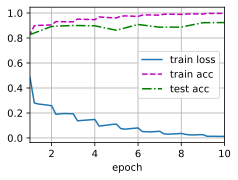

In [16]:
lr, num_epochs = 0.05, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)